# Analysis
**BirdLife KBA Change Detection**

Author: Michael Dear, April 2024

## Usage
This notebook should be run after completing the [Data Extraction]() notebook and exporting the data as `.nc`. The Analysis notebook can be run by first downloading the two `.nc` files exported from the Data Extraction notebook, or from within the [Digital Earth Australia Sandbox](https://app.sandbox.dea.ga.gov.au/).

## Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import xarray as xr
import rioxarray
import numpy as np
import pandas as pd
import geopandas as gpd

# Turn off warnings
import warnings
warnings.filterwarnings('ignore')

### Global Parameters
* Global parameters are used in multiple places
* Local parameters should be found above the relevant code

Description
* kba_name: This has to match the name in the KBA_polygon dataset. See KBA_names.csv for a list of names.
* kba_abbrev: Abbreviation for the KBA. This will be added to file output rather than the full KBA name.

In [56]:
input_dir = 'input/'
output_dir = 'output/'

kba_name = 'Coffin Bay' 
kba_abbrev = 'CB'
current_year = 2024 # The dataset will include this year plus the 5 previous years

spatial_res = 100 # Spatial resolution of the raster dataset in metres
crs = 3577

## Step 1: Load data

In [9]:
ds=xr.load_dataset(input_dir+'raster/'+kba_abbrev+'_KBA_'+str(current_year-5)+'-'+str(current_year)+'.nc')

In [10]:
ds_5yr = xr.load_dataset(input_dir+'raster/'+kba_abbrev+'_KBA_'+str(current_year-5)+'-'+str(current_year)+'_5-year.nc')

In [11]:
mask = xr.load_dataarray(input_dir+'raster/'+kba_abbrev+'_KBA_'+'mask.nc')

In [57]:
# Load the polygon
poly = gpd.read_file(input_dir+'vector/BirdLife_KBA_Australia_2022.sqlite').query('name==@kba_name')

# Set the crs to 4326, then convert to projected crs
poly = poly.set_crs(4326).to_crs(3577)

## Step 2: Plots
<a id='plots'></a>
The following plots compare the current year to the 5-year mean and the previous year. High-resolution versions are saved in the `ouput` directory for closer visual assessment. The plots are a quicker alternative than loading the exported geoTIFF's into a GIS.

### Plotting Parameters and Functions

In [13]:
# Main plot parameters
rgb_vars = ['nbart_red', 'nbart_green', 'nbart_blue']
rgb_params = {
    'robust':True,
}

ndvi_params = {
    'robust':True,
    'cmap':'RdYlGn',
    'add_colorbar':False,
    'vmin':0,
    'vmax':1
}

ndvi_class_params = {
    'levels':[1,2,3,4,5,6], 
    'cmap':'RdYlGn',
    'add_colorbar':False,
}


In [14]:
def remove_labels_ticks(ax):
    '''
    Remove axis labels and ticks from subplots.
    '''
    ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    ax.set_xlabel('')
    ax.set_ylabel('')

### True-colour (RGB)
*Note*: For `imshow`, the rgb values need to be converted to decimal by dividing by $2^{12}$ (Sentinel 2 is 12 bit), then scaling to 255 before converting to `np.unit8`. See https://stackoverflow.com/questions/49643907/clipping-input-data-to-the-valid-range-for-imshow-with-rgb-data-0-1-for-floa

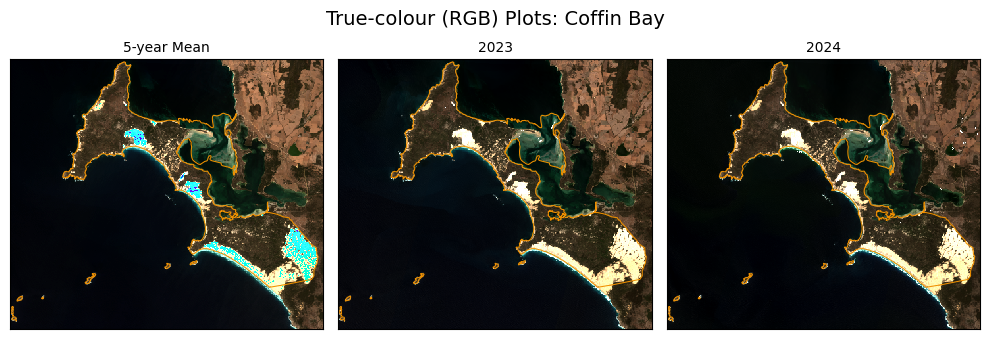

In [79]:
fig, axes = plt.subplots(1,3, figsize=(10,3.5))

subplot_titles = ['5-year Mean', current_year-1, current_year]

(
 (ds_5yr[rgb_vars]
 .to_array()/2**12*255) 
 .astype(np.uint8)
 .plot
 .imshow(ax=axes[0], **rgb_params)
)

(
 ds[rgb_vars]
 .sel(year=current_year-1)
 .to_array()
 .plot
 .imshow(ax=axes[1], **rgb_params)
)

(
 ds[rgb_vars]
 .sel(year=current_year)
 .to_array()
 .plot
 .imshow(ax=axes[2], **rgb_params)
)

for i, ax in enumerate(axes.flat):
    remove_labels_ticks(ax)
    ax.set_title(subplot_titles[i], fontsize=10)
    poly.boundary.plot(ax=ax, linewidth=0.75, color='#f09000')
    
fig.suptitle('True-colour (RGB) Plots: '+kba_name, fontsize=14)
fig.tight_layout()

# bbox_inches = "tight" is required to stop labels at edges being cut off
# https://stackoverflow.com/questions/35992492/savefig-cuts-off-title
fig.savefig(output_dir+'img/'+kba_abbrev+'_RGB_plots.png', dpi=600, bbox_inches = "tight");

### NDVI

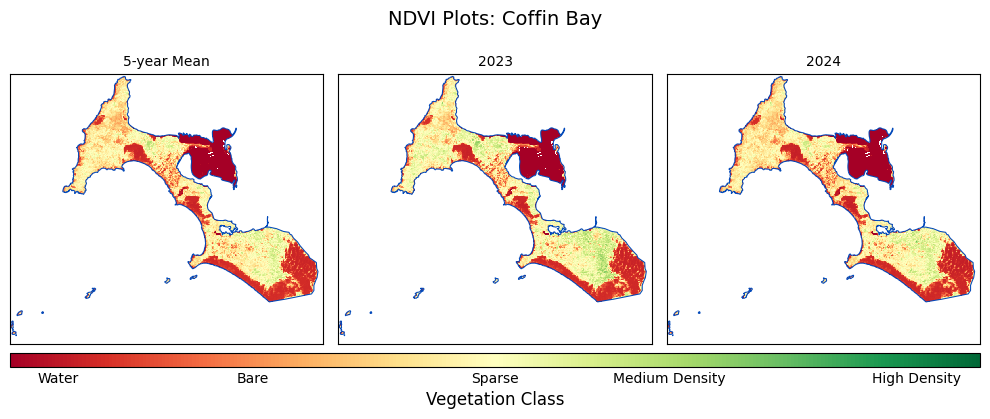

In [80]:
fig, axes = plt.subplots(1,3, figsize=(10,3.5))

subplot_titles = ['5-year Mean', current_year-1, current_year]

colour = (
 ds_5yr
 .where(mask.notnull())
 .NDVI
 .plot(ax=axes[0], **ndvi_params)
)

(
 ds
 .where(mask.notnull())
 .NDVI
 .sel(year=current_year-1)
 .plot(ax=axes[1], **ndvi_params)
)

(
 ds
 .where(mask.notnull())
 .NDVI
 .sel(year=current_year)
 .plot(ax=axes[2], **ndvi_params)
)

for i, ax in enumerate(axes.flat):
    remove_labels_ticks(ax)
    ax.set_title(subplot_titles[i], fontsize=10)
    poly.boundary.plot(ax=ax, linewidth=0.75, color='#0249ba')


fig.suptitle('NDVI Plots: '+kba_name, y=1.02, fontsize=14)
fig.tight_layout()

# Add colorbar - horizontal at bottom
cax = fig.add_axes([0.015, 0, 0.97, 0.04]) # Horizontal at bottom
cb = fig.colorbar(
                          colour, 
                          cax=cax, 
                          orientation = 'horizontal', 
                         )

cb.set_ticks([0.05, 0.25, 0.5, 0.68, 0.935])
cb.set_ticklabels(['Water', 'Bare', 'Sparse', 'Medium Density', 'High Density'])
cb.ax.tick_params(size=0)
cb.set_label('Vegetation Class', fontsize=12)

# bbox_inches = "tight" is required to stop labels at edges being cut off
# https://stackoverflow.com/questions/35992492/savefig-cuts-off-title
fig.savefig(output_dir+'img/'+kba_abbrev+'_NDVI_plots.png', dpi=600, bbox_inches = "tight");

### NDVI Classification

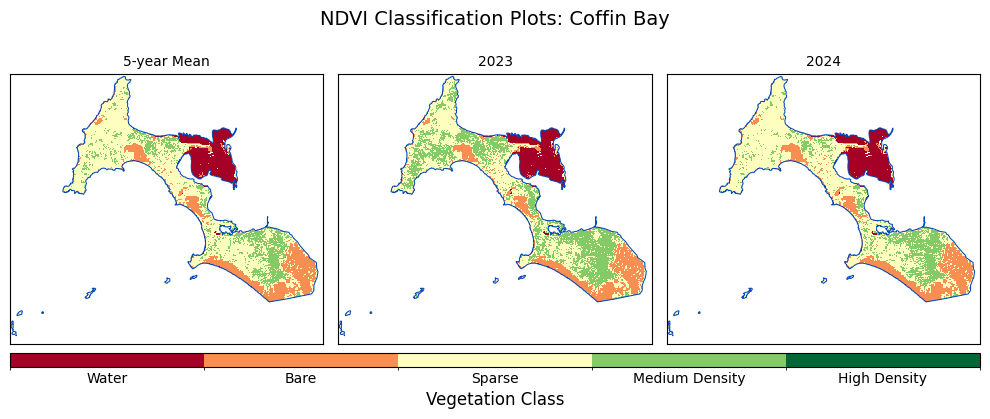

In [81]:
fig, axes = plt.subplots(1,3, figsize=(10,3.5))

subplot_titles = ['5-year Mean', current_year-1, current_year]

colour = (
 ds_5yr
 .where(mask.notnull())
 .NDVI_Class
 .plot(ax=axes[0], **ndvi_class_params)
)

(
 ds
 .where(mask.notnull())
 .NDVI_Class
 .sel(year=current_year-1)
 .plot(ax=axes[1], **ndvi_class_params)
)

(
 ds
 .where(mask.notnull())
 .NDVI_Class
 .sel(year=current_year)
 .plot(ax=axes[2], **ndvi_class_params)
)

for i, ax in enumerate(axes.flat):
    remove_labels_ticks(ax)
    ax.set_title(subplot_titles[i], fontsize=10)
    poly.boundary.plot(ax=ax, linewidth=0.75, color='#0249ba')


fig.suptitle('NDVI Classification Plots: '+kba_name, y=1.02, fontsize=14)
fig.tight_layout()

# Add colorbar - horizontal at bottom
cax = fig.add_axes([0.015, 0, 0.97, 0.04]) # Horizontal at bottom
cb = fig.colorbar(
                          colour, 
                          cax=cax, 
                          orientation = 'horizontal', 
                         )

cb.set_ticks([1.5,2.5,3.5,4.5,5.5])
cb.set_ticklabels(['Water', 'Bare', 'Sparse', 'Medium Density', 'High Density'])
cb.ax.tick_params(size=0)
cb.set_label('Vegetation Class', fontsize=12)

# bbox_inches = "tight" is required to stop labels at edges being cut off
# https://stackoverflow.com/questions/35992492/savefig-cuts-off-title
fig.savefig(output_dir+'img/'+kba_abbrev+'_NDVI_Class_plots.png', dpi=600, bbox_inches = "tight");

## Step 7: NDVI Class Change Statistics
This section examines the change in the number of pixels from the 5-year mean to the current year and from the previous year to the current year. The change is reported as the absolute and proportional pixel change. All statistics are based on the KBA internal area, excluding the surrounding area. 

*Note*: Boundary pixels have been counted as part of the KBA internal area.

### Time step statistics

In [65]:
# Study area stats
print('Bounding box area =',ds.sizes['x']*ds.sizes['y'],'ha')
print('KBA area (pixels) =', mask.count().values, 'ha')
print('KBA area (polygon) =', int(poly.area.values/10**4), 'ha')
print('KBA area as % of bounding box area=', np.round(mask.count().values/(ds.sizes['x']*ds.sizes['y'])*100, 1), '%')

Bounding box area = 196047 ha
KBA area (pixels) = 34766 ha
KBA area (polygon) = 34835 ha
KBA area as % of bounding box area= 17.7 %


In [66]:
da_dict = {
           'current_year':ds.NDVI_Class.sel(year=current_year).where(mask.notnull()), 
           'previous_year': ds.NDVI_Class.sel(year=current_year-1).where(mask.notnull()),
           'mean_5_years': ds_5yr.NDVI_Class.where(mask.notnull())
          }

In [67]:
pd.DataFrame(
    data = [[int(da.where(da == cl).count().values) for cl in np.arange(1,7)] for name, da in da_dict.items()],
    index=[key for key, val in da_dict.items()],
    columns = ['Water', 'Bare', 'Sparse', 'Medium Density', 'High Density', 'Masked']
)

,Water,Bare,Sparse,Medium Density,High Density,Masked
current_year,4162,6874,17982,5727,0,21
previous_year,4189,6523,13431,10601,0,22
mean_5_years,4210,6735,18266,5555,0,0


### Class change statistics
This section investigates the change between classes between the current year and the previous year, and the current year and the mean of the previous five years.

In [68]:
def change_mat(arrs, cl_labels):
    '''
    Create a change matrix from a list of exactly two data arrays.
    The data array values represent classes for the same classification method.
    Rows will represent the first array and columns will represent the second array in the returned data frame.
    
    arrs: Two data arrays of the same size and shape.
    cl_labels: A list of all the class labels used in the classification. 
    There can be a maximum of 256 classes. 
    The label list needs to match the ascending order of the class numbers in the array values.
    '''
    
    # Create the pairs of corresponding class values
    tuples = (list(zip(arrs[0].values.reshape(-1), arrs[1].values.reshape(-1))))
    
    # Get the unique pairs and their frequencies
    # https://stackoverflow.com/a/51793947/8299958
    unique, counts = np.unique(tuples, axis=0, return_counts=True)
    
   
    # Strip pairs containing any nan
    sel = np.array(~np.isnan(unique).any(axis=1))
    counts = counts[sel]
    unique = unique[sel]
  
    
    # Create an empty matrix with dimensions equal to the number of classes
    num_cl = len(cl_labels)
    mat = np.zeros((num_cl,num_cl), dtype=np.int32)
    
    # Fill the matrix
    for n in np.arange(len(unique)):
        row = (unique[n][0]-1 ).astype(np.uint8) # row index
        col = (unique[n][1]-1 ).astype(np.uint8) # column index
        mat[row, col] = counts[n] # update the matrix
    
    # Create the data frame
    df = pd.DataFrame(
            data = mat,
            index = cl_labels,
            columns = cl_labels
            )
    
    # Proportional data frame as a percentage of row total
    # https://stackoverflow.com/a/50820765/8299958
    df_prop = df.div(df.sum(axis=1), axis=0).round(3)*100
    
    return (df, df_prop)

In [69]:
cl_labels = ['Water', 'Bare', 'Sparse', 'Medium Density', 'High Density', 'Masked']

In [72]:
change_mat_prev_curr = change_mat([da_dict['previous_year'], da_dict['current_year']], cl_labels)

In [73]:
change_mat_prev_curr[0]

,Water,Bare,Sparse,Medium Density,High Density,Masked
Water,4063,120,2,0,0,4
Bare,91,6410,20,0,0,2
Sparse,4,342,13019,63,0,3
Medium Density,0,0,4933,5663,0,5
High Density,0,0,0,0,0,0
Masked,4,2,8,1,0,7


In [74]:
change_mat_prev_curr[1]

,Water,Bare,Sparse,Medium Density,High Density,Masked
Water,97.0,2.9,0.0,0.0,0.0,0.1
Bare,1.4,98.3,0.3,0.0,0.0,0.0
Sparse,0.0,2.5,96.9,0.5,0.0,0.0
Medium Density,0.0,0.0,46.5,53.4,0.0,0.0
High Density,NaN,NaN,NaN,NaN,NaN,NaN
Masked,18.2,9.1,36.4,4.5,0.0,31.8


In [75]:
change_mat_5yr_mean_curr = change_mat([da_dict['mean_5_years'], da_dict['current_year']], cl_labels)

In [76]:
change_mat_5yr_mean_curr[0]

,Water,Bare,Sparse,Medium Density,High Density,Masked
Water,4067,133,0,0,0,10
Bare,95,6575,63,0,0,2
Sparse,0,166,17172,923,0,5
Medium Density,0,0,747,4804,0,4
High Density,0,0,0,0,0,0
Masked,0,0,0,0,0,0


In [77]:
change_mat_5yr_mean_curr[1]

,Water,Bare,Sparse,Medium Density,High Density,Masked
Water,96.6,3.2,0.0,0.0,0.0,0.2
Bare,1.4,97.6,0.9,0.0,0.0,0.0
Sparse,0.0,0.9,94.0,5.1,0.0,0.0
Medium Density,0.0,0.0,13.4,86.5,0.0,0.1
High Density,NaN,NaN,NaN,NaN,NaN,NaN
Masked,NaN,NaN,NaN,NaN,NaN,NaN
